#1. 数据准备

###读取 CSV 文件：使用 pandas 读取存储预测值和评分的 CSV 文件。

###合并数据：如果每个模型的预测结果在不同的表格中，你可以通过 ID 或样本的标识符将它们合并成一个大表格。

In [50]:
import pandas as pd
models_preds = pd.read_csv('val/model_preds_merge_DL2_800_222.csv')
models_preds

,ID,Predicted_Label_model1,score_model1,Predicted_Label_model2,score_model2,Predicted_Label_model3,score_model3,True_Label,final_prediction_score,final_prediction,Unnamed: 10
0,5220 ZHANG XI HUI.nii.gz,1,0.265349,1,0.994467,1,0.882103,1,0.865373,1,NaN
1,xiesiyuan-MR039125.nii.gz,1,0.323471,1,0.998751,1,0.850467,1,0.857081,1,NaN
2,6620Zhang Xing Hui.nii.gz,0,0.109538,1,0.998546,1,0.861099,1,0.840922,1,NaN
3,4848 GU YUN LI.nii.gz,0,0.064228,1,0.932053,1,0.918730,1,0.838609,1,NaN
4,6321Zhang Guang Mei.nii.gz,0,0.109095,1,0.989805,1,0.858777,1,0.836220,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...
183,6285Zhou Ying.nii.gz,0,0.069827,0,0.045154,0,0.021403,0,0.035746,0,NaN
184,6561Zhang Zhong Zhen.nii.gz,0,0.085846,0,0.043939,0,0.010223,0,0.031272,0,NaN
185,6215Chen Yong Fen.nii.gz,0,0.095251,0,0.030498,0,0.015576,0,0.029512,0,NaN
186,6776Yuan Zi Ran.nii.gz,0,0.067034,0,0.043921,0,0.008061,0,0.028302,0,NaN


In [51]:

# print(models_preds)
# 读取模型的性能指标
model_metrics = pd.read_csv('pred_csv/model_metrics.csv')

# 假设模型名称和相应的权重存储在一个字典中
weights = {'model1': 0.1, 'model2': 0.4, 'model3': 0.5}
print(weights)


# 计算加权投票
def weighted_voting(row):
    total_weight = sum(weights.values())
    weighted_scores = {}
    
    for model, weight in weights.items():
        weighted_scores[model] = row[f'score_{model}'] * weight

    # 计算加权总分
    weighted_sum = sum(weighted_scores.values())
    return weighted_sum

# 应用加权投票
models_preds['final_prediction_score'] = models_preds.apply(weighted_voting, axis=1)


{'model1': 0.1, 'model2': 0.4, 'model3': 0.5}


In [52]:
models_preds.to_csv('val/model_preds_final_pred.csv', index=False)

2. 加权投票
获取模型的权重：从包含模型 AUC 和准确率（acc）的表格中提取权重。可以根据 AUC 或准确率来决定权重，例如，使用 AUC 作为权重。
计算加权投票：对每个样本的预测进行加权，选择加权和最高的类作为最终预测。

In [53]:
from sklearn.metrics import roc_curve, auc
import numpy as np
# 假设 y_true 是真实标签，y_scores 是模型的预测分数
y_true = models_preds['True_Label']
# y_scores = models_preds[[f'score_{model}' for model in weights.keys()]].mean(axis=1)  # 取平均作为预测分数
y_scores = models_preds['final_prediction_score']
# 计算 ROC 曲线
fpr, tpr, thresholds = roc_curve(y_true, y_scores)

# 计算 AUC
roc_auc = auc(fpr, tpr)
print(roc_auc)

# 选择最佳阈值（例如，TPR 和 FPR 相等的点）
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

print(f'Optimal Threshold: {optimal_threshold}')


0.9305521472392638
Optimal Threshold: 0.38225085270000003


In [54]:
#通过阈值筛选后，保存预测是label值为final_prediction列
import pandas as pd
models_preds = pd.read_csv('val/model_preds_final_pred.csv')

In [55]:
#使用测试集的真实标签评估最终模型的性能，如计算 AUC 和准确率
from sklearn.metrics import accuracy_score, roc_auc_score

y_true= models_preds['True_Label']
y_pred=models_preds['final_prediction']
y_scores = models_preds['final_prediction_score']
# 假设真实标签存储在 'true_labels' 列中
accuracy = accuracy_score(y_true, y_pred)
auc = roc_auc_score(y_true, y_scores, average='macro', multi_class='ovr')

print(f'Final Model Accuracy: {accuracy}')
print(f'Final Model AUC: {auc}')


Final Model Accuracy: 0.8723404255319149
Final Model AUC: 0.9305521472392638


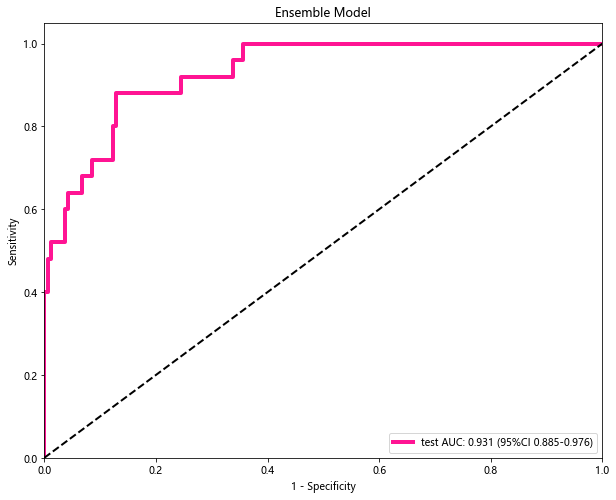

In [56]:
import onekey_algo.custom.components as okcomp
import matplotlib.pyplot as plt
okcomp.comp1.draw_roc_test_only(y_true, y_scores, title='Ensemble Model')
plt.savefig(f'img/ensemble_roc.tif', bbox_inches = 'tight')

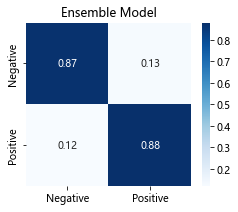

In [57]:
cm = okcomp.comp1.calc_confusion_matrix(y_pred,y_true,class_mapping={1:'Positive', 0:'Negative'})
plt.figure(figsize=(3.7,3))
plt.title(f'Ensemble Model')
okcomp.comp1.draw_matrix(cm, norm=True, annot=True, cmap='Blues')
plt.savefig(f'img/Ensemble-CM.tif', bbox_inches = 'tight',dpi=300)

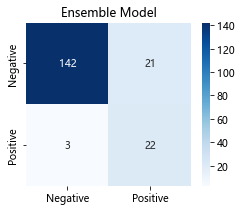

In [58]:
cm = okcomp.comp1.calc_confusion_matrix(y_pred,y_true,class_mapping={1:'Positive', 0:'Negative'})
plt.figure(figsize=(3.7,3))
plt.title(f'Ensemble Model')
okcomp.comp1.draw_matrix(cm, norm=False, annot=True, cmap='Blues')
plt.savefig(f'img/Ensemble-CM1.tif', bbox_inches = 'tight',dpi=300)

In [59]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_true, y_pred)
print('Accuracy:', accuracy)

Accuracy: 0.8723404255319149


In [1]:
import pandas as pd
models_preds = pd.read_csv('yz2024/model_preds_merge.csv')

In [2]:
# print(models_preds)
# 读取模型的性能指标
#model_metrics = pd.read_csv('pred_csv/model_metrics.csv')

# 假设模型名称和相应的权重存储在一个字典中
weights = {'model1':0.1, 'model2': 0.4, 'model3': 0.5}
print(weights)


# 计算加权投票
def weighted_voting(row):
    total_weight = sum(weights.values())
    weighted_scores = {}
    
    for model, weight in weights.items():
        weighted_scores[model] = row[f'score_{model}'] * weight

    # 计算加权总分
    weighted_sum = sum(weighted_scores.values())
    return weighted_sum

# 应用加权投票
models_preds['final_prediction_score'] = models_preds.apply(weighted_voting, axis=1)

{'model1': 0.1, 'model2': 0.4, 'model3': 0.5}


In [3]:
models_preds.to_csv('yz2024/model_preds_final_pred.csv', index=False)

In [4]:
optimal_threshold = 0.38225085270000003
print(f'Optimal Threshold: {optimal_threshold}')


Optimal Threshold: 0.38225085270000003


In [5]:
#通过阈值筛选后，保存预测是label值为final_prediction列
import pandas as pd
models_preds = pd.read_csv('yz2024/model_preds_final_pred.csv')

In [6]:
#使用测试集的真实标签评估最终模型的性能，如计算 AUC 和准确率
from sklearn.metrics import accuracy_score, roc_auc_score

y_true= models_preds['True_label']
y_pred=models_preds['final_prediction']
y_scores = models_preds['final_prediction_score']
# 假设真实标签存储在 'true_labels' 列中
accuracy = accuracy_score(y_true, y_pred)
auc = roc_auc_score(y_true, y_scores, average='macro', multi_class='ovr')

print(f'Final Model Accuracy: {accuracy}')
print(f'Final Model AUC: {auc}')

Final Model Accuracy: 0.8208955223880597
Final Model AUC: 0.8606557377049181


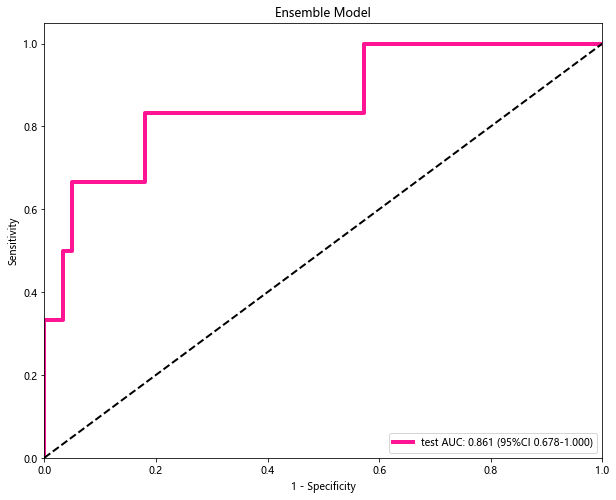

In [7]:
import onekey_algo.custom.components as okcomp
import matplotlib.pyplot as plt
okcomp.comp1.draw_roc_test_only(y_true, y_scores, title='Ensemble Model')
plt.savefig(f'img/ensemble_roc.tif', bbox_inches = 'tight')

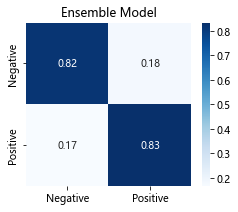

In [8]:
cm = okcomp.comp1.calc_confusion_matrix(y_pred,y_true,class_mapping={1:'Positive', 0:'Negative'})
plt.figure(figsize=(3.7,3))
plt.title(f'Ensemble Model')
okcomp.comp1.draw_matrix(cm, norm=True, annot=True, cmap='Blues')
plt.savefig(f'img/Ensemble-CM.tif', bbox_inches = 'tight',dpi=300)

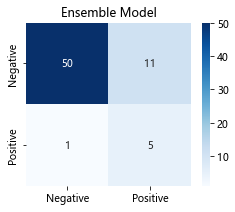

In [9]:
cm = okcomp.comp1.calc_confusion_matrix(y_pred,y_true,class_mapping={1:'Positive', 0:'Negative'})
plt.figure(figsize=(3.7,3))
plt.title(f'Ensemble Model')
okcomp.comp1.draw_matrix(cm, norm=False, annot=True, cmap='Blues')
plt.savefig(f'img/Ensemble-CM1.tif', bbox_inches = 'tight',dpi=300)

In [28]:
import pandas as pd
models_preds = pd.read_csv('st/model_preds_merge_111.csv')

In [29]:
# print(models_preds)
# 读取模型的性能指标
#model_metrics = pd.read_csv('pred_csv/model_metrics.csv')

# 假设模型名称和相应的权重存储在一个字典中
weights = {'model1': 0.1, 'model2': 0.4, 'model3': 0.5}
print(weights)


# 计算加权投票
def weighted_voting(row):
    total_weight = sum(weights.values())
    weighted_scores = {}
    
    for model, weight in weights.items():
        weighted_scores[model] = row[f'score_{model}'] * weight

    # 计算加权总分
    weighted_sum = sum(weighted_scores.values())
    return weighted_sum

# 应用加权投票
models_preds['final_prediction_score'] = models_preds.apply(weighted_voting, axis=1)

{'model1': 0.1, 'model2': 0.4, 'model3': 0.5}


In [30]:
models_preds.to_csv('st/model_preds_final_pred.csv', index=False)

In [13]:
optimal_threshold = 0.38225085270000003

In [36]:
#通过阈值筛选后，保存预测是label值为final_prediction列
import pandas as pd
models_preds = pd.read_csv('st/model_preds_final_pred.csv')

In [37]:
#使用测试集的真实标签评估最终模型的性能，如计算 AUC 和准确率
from sklearn.metrics import accuracy_score, roc_auc_score

y_true= models_preds['True_label']
y_pred=models_preds['final_prediction']
y_scores = models_preds['final_prediction_score']
# 假设真实标签存储在 'true_labels' 列中
accuracy = accuracy_score(y_true, y_pred)
auc = roc_auc_score(y_true, y_scores, average='macro', multi_class='ovr')

print(f'Final Model Accuracy: {accuracy}')
print(f'Final Model AUC: {auc}')

Final Model Accuracy: 0.7393617021276596
Final Model AUC: 0.7617468214483142


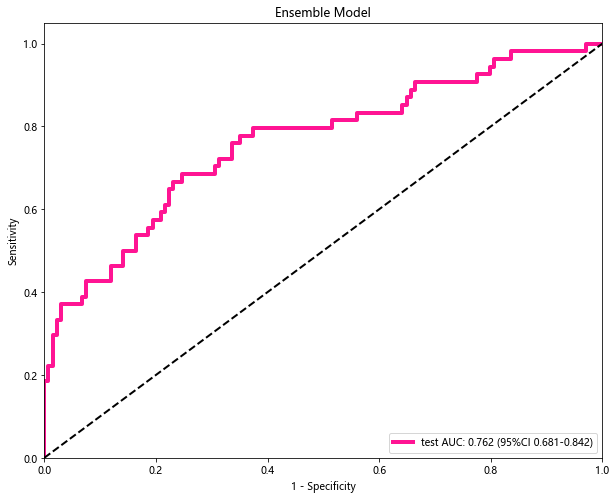

In [38]:
import onekey_algo.custom.components as okcomp
import matplotlib.pyplot as plt
okcomp.comp1.draw_roc_test_only(y_true, y_scores, title='Ensemble Model')
plt.savefig(f'st/ensemble_roc_0107.tif', bbox_inches = 'tight')

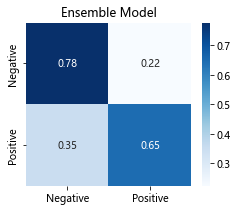

In [39]:
cm = okcomp.comp1.calc_confusion_matrix(y_pred,y_true,class_mapping={1:'Positive', 0:'Negative'})
plt.figure(figsize=(3.7,3))
plt.title(f'Ensemble Model')
okcomp.comp1.draw_matrix(cm, norm=True, annot=True, cmap='Blues')
plt.savefig(f'st/Ensemble-CM.tif', bbox_inches = 'tight',dpi=300)

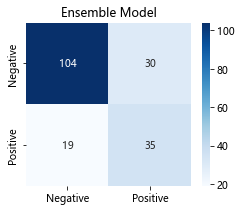

In [40]:
cm = okcomp.comp1.calc_confusion_matrix(y_pred,y_true,class_mapping={1:'Positive', 0:'Negative'})
plt.figure(figsize=(3.7,3))
plt.title(f'Ensemble Model')
okcomp.comp1.draw_matrix(cm, norm=False, annot=True, cmap='Blues')
plt.savefig(f'st/Ensemble-CM1.tif', bbox_inches = 'tight',dpi=300)

In [ ]:
import pandas as pd
models_preds = pd.read_csv('st/model_preds_merge_111.csv')

In [ ]:
# 假设模型名称和相应的权重存储在一个字典中
weights = {'model1': 0.1, 'model2': 0.4, 'model3': 0.5}
print(weights)


# 计算加权投票
def weighted_voting(row):
    total_weight = sum(weights.values())
    weighted_scores = {}
    
    for model, weight in weights.items():
        weighted_scores[model] = row[f'score_{model}'] * weight

    # 计算加权总分
    weighted_sum = sum(weighted_scores.values())
    return weighted_sum

# 应用加权投票
models_preds['final_prediction_score'] = models_preds.apply(weighted_voting, axis=1)

In [ ]:
models_preds.to_csv('st/model_preds_final_pred.csv', index=False)

In [ ]:
optimal_threshold = 0.38225085270000003

In [ ]:
#通过阈值筛选后，保存预测是label值为final_prediction列
import pandas as pd
models_preds = pd.read_csv('st/model_preds_final_pred.csv')

## 通过Venn图展示每个模型预测错误的样本交集情况

In [41]:
import numpy as np
import matplotlib.pyplot as plt
# from matplotlib_venn import venn3

In [42]:
import pandas as pd
models_preds = pd.read_csv('val/DL_800_222/model_preds_final_pred.csv')
models_preds

,ID,Predicted_Label_model1,score_model1,Predicted_Label_model2,score_model2,Predicted_Label_model3,score_model3,True_Label,final_prediction_score,final_prediction
0,5220 ZHANG XI HUI.nii.gz,1,0.265349,1,0.994467,1,0.882103,1,0.865373,1
1,xiesiyuan-MR039125.nii.gz,1,0.323471,1,0.998751,1,0.850467,1,0.857081,1
2,6620Zhang Xing Hui.nii.gz,0,0.109538,1,0.998546,1,0.861099,1,0.840922,1
3,4848 GU YUN LI.nii.gz,0,0.064228,1,0.932053,1,0.918730,1,0.838609,1
4,6321Zhang Guang Mei.nii.gz,0,0.109095,1,0.989805,1,0.858777,1,0.836220,1
...,...,...,...,...,...,...,...,...,...,...
183,6285Zhou Ying.nii.gz,0,0.069827,0,0.045154,0,0.021403,0,0.035746,0
184,6561Zhang Zhong Zhen.nii.gz,0,0.085846,0,0.043939,0,0.010223,0,0.031272,0
185,6215Chen Yong Fen.nii.gz,0,0.095251,0,0.030498,0,0.015576,0,0.029512,0
186,6776Yuan Zi Ran.nii.gz,0,0.067034,0,0.043921,0,0.008061,0,0.028302,0


In [43]:
# 假设有三个模型的预测标签和真实标签
# 每个模型的预测标签：0代表错误预测，1代表正确预测
true_labels = models_preds['True_Label']  # 真实标签
predictions_model1 = models_preds['Predicted_Label_model1'] # 模型1的预测
predictions_model2 = models_preds['Predicted_Label_model2']  # 模型2的预测
predictions_model3 = models_preds['Predicted_Label_model3']  # 模型3的预测
predictions_modelen = models_preds['final_prediction']  # 模型ensemble的预测

In [44]:
# 计算错误样本（预测错误的样本标签为0）
errors_model1 = predictions_model1 != true_labels
errors_model2 = predictions_model2 != true_labels
errors_model3 = predictions_model3 != true_labels
errors_modelen = predictions_modelen != true_labels

In [45]:
# 计算三个模型错误样本的交集情况
# 使用集合交集运算符 & 来计算每个模型错误样本的交集
set_model1 = set(np.where(errors_model1)[0])
set_model2 = set(np.where(errors_model2)[0])
set_model3 = set(np.where(errors_model3)[0])
set_modelen = set(np.where(errors_modelen)[0])


In [46]:
set_model1

{2,
 3,
 4,
 5,
 6,
 7,
 10,
 13,
 14,
 15,
 22,
 24,
 27,
 28,
 29,
 31,
 32,
 34,
 38,
 41,
 44,
 55,
 60,
 67,
 76,
 78,
 80,
 83,
 96,
 103,
 121,
 123,
 131,
 174}

In [47]:
set_model2

{10,
 13,
 15,
 16,
 17,
 18,
 21,
 23,
 24,
 25,
 26,
 27,
 29,
 30,
 31,
 32,
 33,
 35,
 36,
 37,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 61,
 62,
 63,
 69,
 70,
 71,
 72,
 78,
 82}

In [48]:
set_model3

{10,
 13,
 15,
 16,
 17,
 18,
 21,
 23,
 24,
 25,
 26,
 28,
 30,
 34,
 38,
 39,
 40,
 41,
 42,
 46,
 65,
 66,
 74,
 85}

In [49]:
set_modelen

{10,
 13,
 15,
 16,
 17,
 18,
 21,
 23,
 24,
 25,
 26,
 28,
 29,
 30,
 32,
 33,
 34,
 35,
 36,
 37,
 40,
 62,
 78,
 82}